# Flatness v.s. Generalization

# PART 2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)

In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
def compute_sensitivity(model, loss_fn, inputs, labels):
    model.eval()
    inputs.requires_grad = True
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()

    sensitivity = torch.norm(inputs.grad.detach(), p='fro')
    return sensitivity.item()


In [4]:
def train_model(model, train_loader, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    return train_loss / len(train_loader), 100 * correct / total


In [5]:
def test_model(model, test_loader, loss_fn, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    return test_loss / len(test_loader), 100 * correct / total


In [6]:
batch_sizes = [8, 32, 128, 512, 2048]
learning_rate = 0.01
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_acc_list, test_acc_list = [], []
train_loss_list, test_loss_list = [], []
sensitivity_list = []


In [7]:
loss_fn = nn.CrossEntropyLoss()

for batch_size in batch_sizes:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, train_loader, optimizer, loss_fn, device)
        test_loss, test_acc = test_model(model, test_loader, loss_fn, device)
        
    data, target = next(iter(train_loader))
    data, target = data.to(device), target.to(device)
    
    sensitivity = compute_sensitivity(model, loss_fn, data, target)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    sensitivity_list.append(sensitivity)

batch_sizes_log = np.log10(batch_sizes)


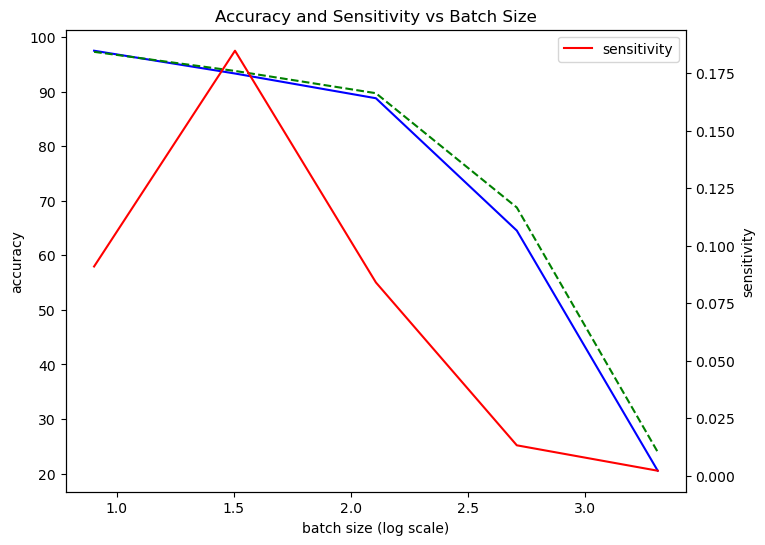

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes_log, train_acc_list, 'b', label='train')
plt.plot(batch_sizes_log, test_acc_list, 'g--', label='test')
plt.ylabel('accuracy')
plt.xlabel('batch size (log scale)')
plt.twinx()
plt.plot(batch_sizes_log, sensitivity_list, 'r', label='sensitivity')
plt.ylabel('sensitivity')
plt.title('Accuracy and Sensitivity vs Batch Size')
plt.legend(loc='upper right')
plt.show()


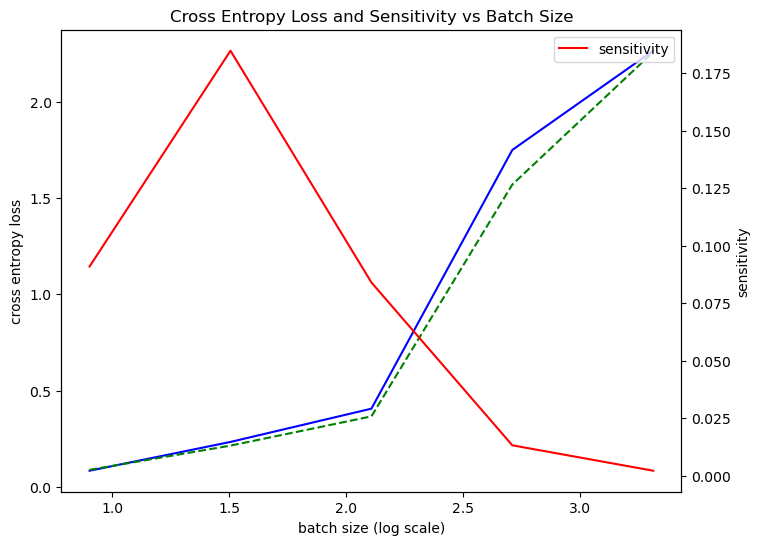

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes_log, train_loss_list, 'b', label='train')
plt.plot(batch_sizes_log, test_loss_list, 'g--', label='test')
plt.ylabel('cross entropy loss')
plt.xlabel('batch size (log scale)')
plt.twinx()
plt.plot(batch_sizes_log, sensitivity_list, 'r', label='sensitivity')
plt.ylabel('sensitivity')
plt.title('Cross Entropy Loss and Sensitivity vs Batch Size')
plt.legend(loc='upper right')
plt.show()